Tasca S8.01. Visualitzacions en Python: The objective is to connect to MySQL Workbench, retrieve data from database tables, and create visualizations to highlight and interpret relevant patterns in the data.

Libraries

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import date
import numpy as np
from scipy.stats import shapiro, spearmanr, pearsonr

# MySQL and environment handling
import mysql.connector
from sqlalchemy import text
from mysql.connector import Error
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

Load the .env file

In [127]:
load_dotenv()

True

Connect to MySQL using SQLAlchemy engine

In [128]:
host=os.getenv("MYSQL_HOST")
user=os.getenv("MYSQL_USER")
password=os.getenv("MYSQL_PASSWORD")
database=os.getenv("MYSQL_DB")

try:
    engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")
    print("✅ SQLAlchemy engine created")

except Error as e:
    print("❌ Error while connecting to MySQL:", e)

✅ SQLAlchemy engine created


Get tables from MySQL

In [129]:
conn  = engine.connect()

try:
    result = conn.execute(text("SHOW TABLES;"))
    tables = [row[0] for row in result]

    dataframes = {}
    for table in tables:
        df = pd.read_sql_table(table, con=engine)
        dataframes[table] = df
        print(f"📄 Table '{table}' loaded with {len(df)} rows")

    for table_name, df in dataframes.items():
        globals()[table_name] = df

finally:
    conn.close()
    print("🔒 Connection closed")


📄 Table 'company' loaded with 100 rows
📄 Table 'credit_card' loaded with 275 rows
📄 Table 'credit_card_status_history' loaded with 275 rows
📄 Table 'product' loaded with 100 rows
📄 Table 'transaction' loaded with 587 rows
📄 Table 'transaction_product' loaded with 1457 rows
📄 Table 'user' loaded with 275 rows
🔒 Connection closed


- Exercici 1
Una variable numèrica

In [130]:
user["birth_date"] = pd.to_datetime(user["birth_date"], format="%b %d, %Y", errors="coerce")

today = date.today()
user["age"] = (
    today.year - user["birth_date"].dt.year - ((today.month < user["birth_date"].dt.month) | ((today.month == user["birth_date"].dt.month) & (today.day < user["birth_date"].dt.day)))
)

# Freedman–Diaconis bin count
q1 = user["age"].quantile(0.25)
q3 = user["age"].quantile(0.75)
iqr = q3 - q1
bin_width = 2 * iqr / (len(user["age"]) ** (1/3))
fd_bins = int(np.ceil((user["age"].max() - user["age"].min()) / bin_width))


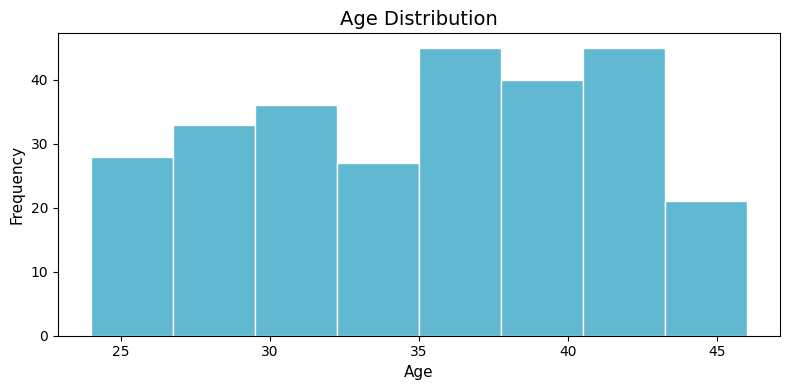

In [149]:
plt.figure(figsize=(8, 4))
sns.histplot(
    data=user,
    x="age",
    bins=fd_bins,
    color= sns.color_palette("YlGnBu")[3],
    edgecolor="white"
)
plt.title(f"Age Distribution", fontsize=14)
plt.xlabel("Age", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.tight_layout()
plt.show()


Age Distribution Summary

In [132]:
counts, bin_edges = np.histogram(user["age"], bins=fd_bins)
bin_labels = [f"{int(bin_edges[i])}–{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
hist_df = pd.DataFrame({
    "Age Range": bin_labels,
    "Count": counts
})

print(hist_df)

mediana = user["age"].median()
print("La mediana es:", mediana)

  Age Range  Count
0     24–26     28
1     26–29     33
2     29–32     36
3     32–35     27
4     35–37     45
5     37–40     40
6     40–43     45
7     43–46     21
La mediana es: 35.0


Age Distribution Interpretation: El eje X muestra rangos de edad y el eje Y, la frecuencia por rango. La mayoría de los usarios están entre 35–37 y 40–43 años. Hay menos personas entre 43–46 años. La distribución es bimodal, con picos en 35–38 y 40–43.

- Exercici 2
Dues variables numèriques.

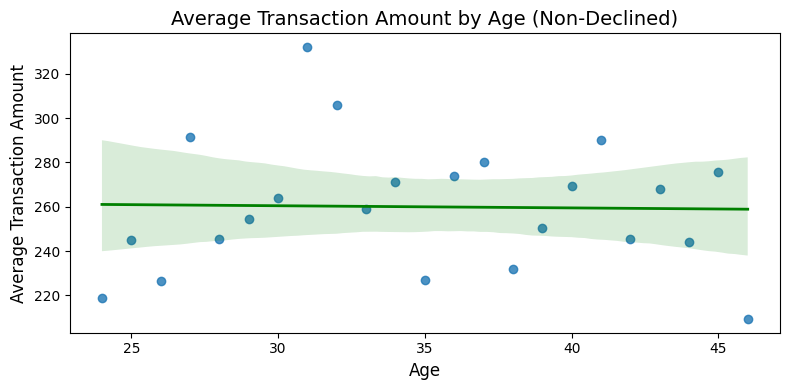

In [150]:
transaction["month"] = pd.to_datetime(transaction['timestamp']).dt.month

successful_transactions = transaction[transaction["declined"] == 0]

merged_successful_transactions_user = (
    pd.merge(
        successful_transactions[["id", "user_id", "amount", "declined", "month"]],
        user[["id", "age", "country"]],
        left_on="user_id",
        right_on="id",
        how="inner"
    )
    .rename(columns={"id_x": "transaction_id", "id_y": "user_id"})
)

avg_amount_age = merged_successful_transactions_user.groupby("age")["amount"].mean().reset_index()


plt.figure(figsize=(8, 4))
sns.regplot(
    data=avg_amount_age,
    x ="age",
    y ="amount",
    line_kws={"color": "green", "linewidth": 2}
)
plt.title("Average Transaction Amount by Age (Non-Declined)", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Average Transaction Amount", fontsize=12)
plt.tight_layout()
plt.show()

Average Transaction Amount by Age (Non-Declined) Interpretation: El gráfico muestra la relación entre la edad y el promedio de transacciones. La línea verde indica la tendencia general: como es casi plana, segnifica que la edad no influye mucho en cuánto gasta un usuario en promedio. La zona verde alrededor es el margen de confianza, que muestra el rango donde se espera que estén los datos reales si la relación entre edad y gasto fuera consistente. Como es ancha, eso significa que los datos varían bastante y el modelo no es muy exacto. Ademas, algunos puntos están fuera de esta zona, lo que indica posibles valores atípicos o que no siguen la tendencia general.

- Exercici 3
Una variable categòrica.

In [134]:
merged_successful_transactions_company_deduplicated = pd.merge(
    company[["company_id", "country"]],
    successful_transactions[["company_id"]].drop_duplicates(subset=["company_id"]),
    on="company_id",
    how="inner"
)

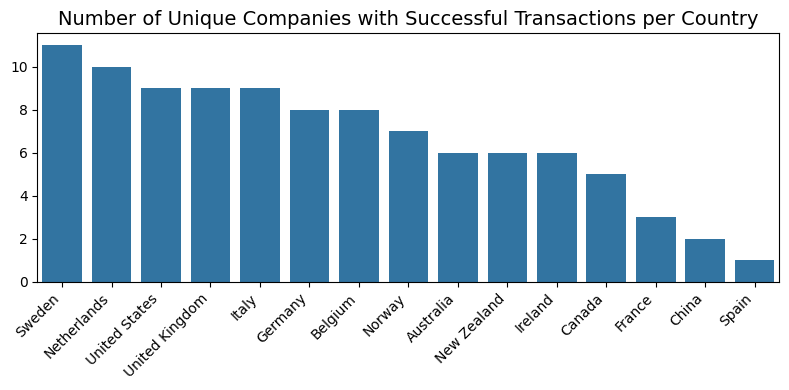

In [151]:
plt.figure(figsize=(8, 4))
sns.countplot(
    data=merged_successful_transactions_company_deduplicated,
    x="country",
    order=merged_successful_transactions_company_deduplicated["country"].value_counts().index 
)
plt.xticks(rotation=45, ha="right")
plt.title("Number of Unique Companies with Successful Transactions per Country", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

Number of Unique Companies with Successful Transactions per Country Interpretación: El eje X muestra los países y el eje Y, la cantidad de compañías únicas que realizaron transacciones exitosas. El mayor número de empresas se encuentra en Suecia, mientras que el menor corresponde a España.

- Exercici 4
Una variable categòrica i una numèrica.

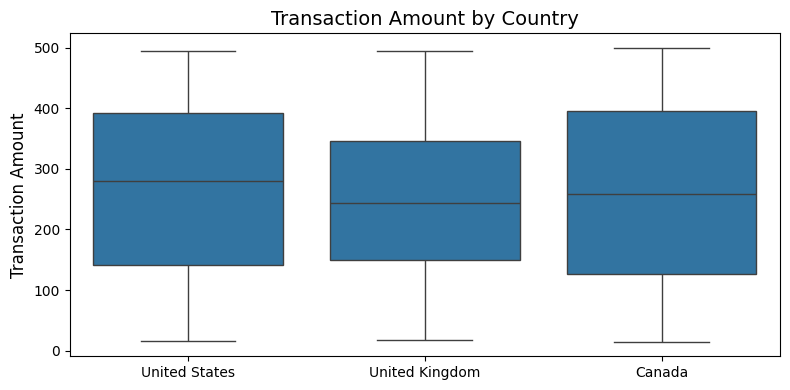

In [152]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=merged_successful_transactions_user,
    x = "country",
    y = "amount",
    legend=False
)

plt.title("Transaction Amount by Country", fontsize=14)
plt.xlabel("")
plt.ylabel("Transaction Amount", fontsize=12)
plt.tight_layout()
plt.show()


Transaction Amount by Country Interpretación: 
El gráfico muestra un boxplot comparando los montos de transacción entre Estados Unidos, Reino Unido y Canadá.
Las medianas son parecidas. Aunque están cerca, la mediana de Estados Unidos es un poco más alta que la de Canadá y Reino Unido. Esto significa que, en general, los montos de transacción en Estados Unidos son un poco más altos.
Canadá tiene más variación en los montos, porque su caja en el boxplot es más grande. Reino Unido tiene la caja más baja, eso significa que la mayoría de los montos de transacción son parecidos entre ellos.


- Exercici 5
Dues variables categòriques.

In [137]:
df_all_transaction_user = pd.merge(
    user[["id", "country", "age"]],
    transaction[["user_id", "declined", "amount"]],
    left_on="id",
    right_on="user_id",
    how="inner"
).rename(columns={"id": "user_id"})

summary_transaction = df_all_transaction_user.groupby('country')['declined'].agg(
    total='count',
    declined='sum'
).reset_index()

summary_transaction['approved'] = summary_transaction['total'] - summary_transaction['declined']

plot_data = summary_transaction.set_index("country")[["approved", "declined"]] \
    .sort_values(by=["approved", "declined"])
plot_data

,approved,declined
country,,
United Kingdom,62,0
United States,173,0
Canada,265,87


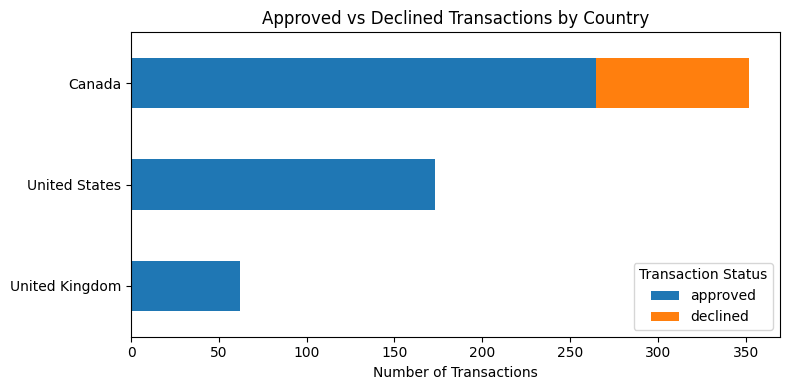

In [153]:
plot_data.plot(kind="barh", stacked=True, figsize=(8, 4))
plt.title("Approved vs Declined Transactions by Country")
plt.xlabel("Number of Transactions")
plt.ylabel("")
plt.legend(title="Transaction Status", loc="lower right")
plt.tight_layout()
plt.show()

Approved vs Declined Transactions by Country Interpretación: 
Este gráfico muestra la cantidad de transacciones aprobadas (en azul) y rechazadas (en naranja) por pais. 
Estados Unidos y Reino Unido tienen todas sus transacciones aprobadas, lo que muestra que el proceso funciona muy bien en esos países.
Canada tiene más transacciones, pero también muchas fueron rechazadas. Esto puede ser una señal de que hay algo que revisar, como errores en el sistema o problemas con los usuarios.

- Exercici 6
Tres variables.

In [139]:
df_monthly_sales = merged_successful_transactions_user.groupby(['country', 'month'])['amount'].sum().reset_index()

sales_pivot = df_monthly_sales.pivot(index='country', columns='month', values='amount')
sales_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
country,,,,,,,,,,,,
Canada,5299.09,5496.30,4255.97,7020.19,7645.38,6049.97,5080.50,7552.51,4467.51,4699.48,4688.26,5799.58
United Kingdom,448.46,1896.24,1710.24,801.54,912.66,1763.28,165.85,1759.97,933.26,1172.14,2223.95,1428.70
United States,2488.76,2685.01,3265.85,5685.95,3101.23,3004.56,4685.42,4587.76,4123.66,4893.95,763.53,6948.88


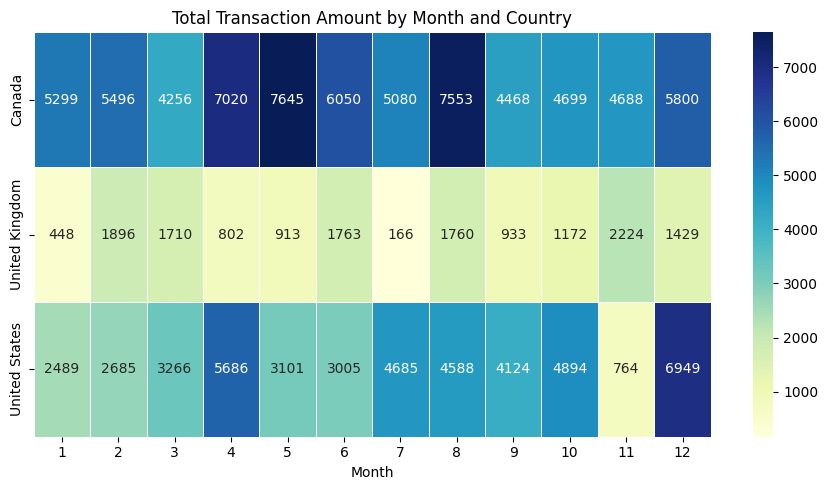

In [154]:
plt.figure(figsize=(9, 5))
sns.heatmap(sales_pivot, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Total Transaction Amount by Month and Country")
plt.xlabel("Month")
plt.ylabel("")
plt.tight_layout()
plt.show()

Total Transaction Amount by Month and Country Interpretación:
Este gráfico muestra el monto total de transacciones por mes y por país para todo el periodo.
Canadá tiene los montos de transacción más altos durante todo el año, especialmente en abril, mayo y agosto.
Estados Unidos tiene montos medianos, con aumentos en abril y diciembre.
Reino Unido tiene los montos más bajos y muy variables.
Abril y diciembre son los meses donde los tres países tienen más transacciones, lo que puede significar que hay eventos especiales como descuentos o compras por festivos.
Como Canada tiene más operaciones que otros paises, los totales  no son suficientes para comparar. Sería útil analizar también los montos promedio por usuario o por transacción para hacer una comparación más justa entre países.


- Exercici 7
Graficar un Pairplot.

<Figure size 1000x600 with 0 Axes>

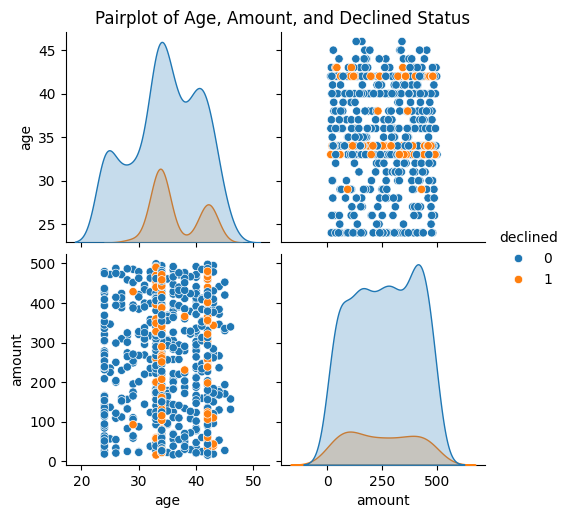

In [141]:
pairplot_data = df_all_transaction_user[["age", "amount", "declined"]]
plt.figure(figsize=(10, 6))
sns.pairplot(data=pairplot_data, hue="declined")
plt.suptitle("Pairplot of Age, Amount, and Declined Status", y=1.02)
plt.show()


Nivell 2
Exercici 1
Correlació de totes les variables numèriques.

Pairplot of Age, Amount, and Declined Status Interpretacion:
Este gráfico muestra cómo se relacionan la edad del usuario, el monto de la transacción y si fue aprobada (azul) o rechazada (naranja).
La mayoría de las transacciones fueron aprobadas. Las transacciones rechazadas son menos y aparecen en diferentes edades y montos.
No se ve una relación clara entre la edad o el monto y el rechazo

In [142]:
successful_transactions_user_product = pd.merge(
    merged_successful_transactions_user,
    transaction_product[["transaction_id", "product_id"]],
    on="transaction_id",
    how="inner"
)

successful_transactions_user_product_price = pd.merge(
    successful_transactions_user_product,
    product[["id", "price"]],
    left_on="product_id",
    right_on="id",
    how="inner"
).rename(columns={"id": "product_id"})

corr_data = successful_transactions_user_product_price[["age", "amount", "price"]]

# Check normality with Shapiro-Wilk test
variables = ["age", "amount", "price"]
normal_vars = []

for var in variables:
    stat, p = shapiro(corr_data[var])
    print(f"{var}: statistic = {stat:.3f}, p-value = {p:.3f}")
    if p > 0.05:
        print(f" → {var} seems to follow a normal distribution.\n")
        normal_vars.append(var)
    else:
        print(f" → {var} does NOT appear to follow a normal distribution.\n")

if len(normal_vars) == 3:
    print("All variables are normally distributed → using Pearson correlation.\n")
    correlation_data = corr_data.corr(method="pearson")
else:
    print(" At least one variable is not normal → using Spearman correlation.\n")
    correlation_data = corr_data.corr(method="spearman")


age: statistic = 0.956, p-value = 0.000
 → age does NOT appear to follow a normal distribution.

amount: statistic = 0.949, p-value = 0.000
 → amount does NOT appear to follow a normal distribution.

price: statistic = 0.934, p-value = 0.000
 → price does NOT appear to follow a normal distribution.

 At least one variable is not normal → using Spearman correlation.



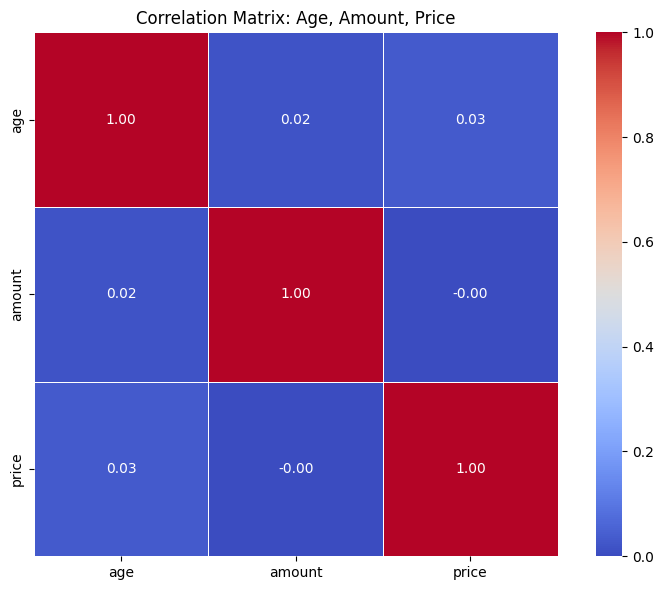

In [143]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Matrix: Age, Amount, Price")
plt.tight_layout()
plt.show()

"Correlation Matrix: Age, Amount, Price" Interpretacion:
Este gráfico muestra la correlación entre la edad del usuario, el monto de la transacción y el precio del producto.
Primero se hizo una prueba de normalidad (Shapiro-Wilk) y los tres valores no tienen distribución normal (p-valor < 0.05). Por eso se usó correlación de Spearman.
Las correlaciones entre las variables son muy cercanas a 0. No hay relación clara entre edad, monto y precio: una variable no cambia de forma consistente con otra.

Exercici 2
Implementa un jointplot.

In [144]:
avg_price = successful_transactions_user_product_price.groupby("transaction_id")["price"].mean().reset_index()

transaction_amount = transaction[["id", "amount"]].rename(columns={"id": "transaction_id"})
transaction_amount_avg_price = pd.merge(transaction_amount, avg_price, on="transaction_id")


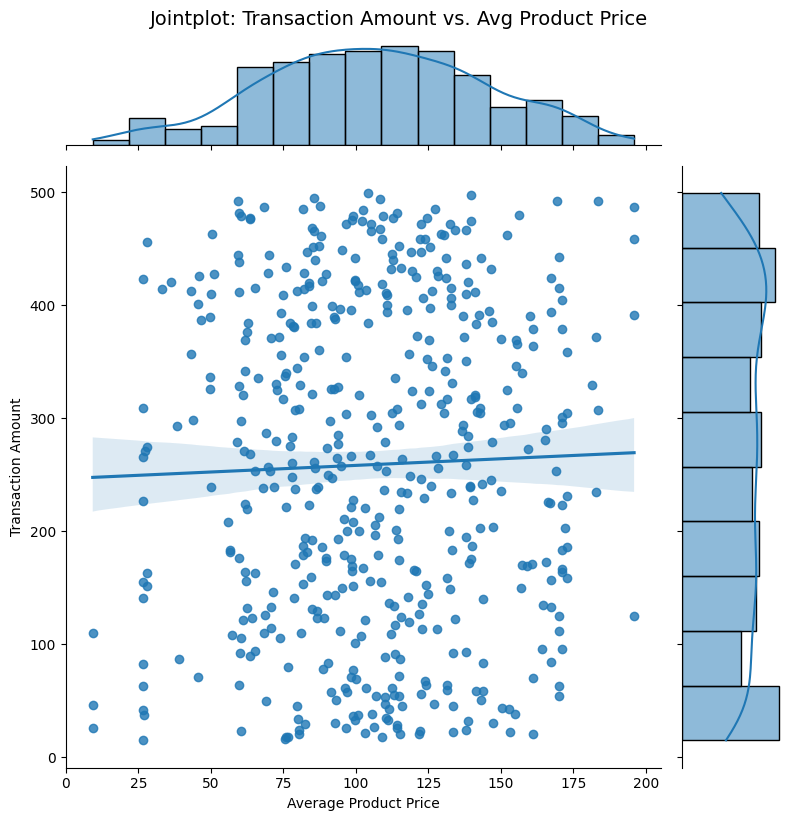

In [145]:
sns.jointplot(
    data = transaction_amount_avg_price,
    x="price",
    y="amount",
    kind="reg",
    height=8,
)

plt.suptitle("Jointplot: Transaction Amount vs. Avg Product Price", fontsize=14, y=1.02)
plt.xlabel("Average Product Price")
plt.ylabel("Transaction Amount")
plt.show()

Jointplot: Transaction Amount vs. Avg Product Price Interpretacion:

Este gráfico muestra la relación entre el precio promedio de un producto y el monto total de la transacción.
La línea azul representa una regresión lineal. Esta línea muestra si, cuando el precio promedio del producto cambia, también cambia el monto total de la transacción, y cómo lo hace. Aunque la línea sube ligeramente, su pendiente es muy baja, lo que indica que no hay una relación  entre estas dos variables.
La sombra azul clara es el intervalo de confianza. En este caso, es bastante ancha, lo que sugiere una alta variabilidad en los datos y y que no se puede estar muy seguro de la relación.
En general, los puntos están muy dispersos, lo que refleja una relación débil o nula entre el precio promedio y el monto total.

Además, los histogramas ayudan a entender cómo se distribuyen las variables por separado. El precio promedio del producto sigue una distribución más o menos normal, con la mayoría de los valores entre 75 y 125. En cambio, el monto de la transacción está más repartido, sin un valor que se repita mucho más que los demás.

En resumen, no se observa una correlación clara entre el precio promedio del producto y el monto total de la transacción

Nivell 3
Exercici 1
Implementa un violinplot combinat amb un altre tipus de gràfic.

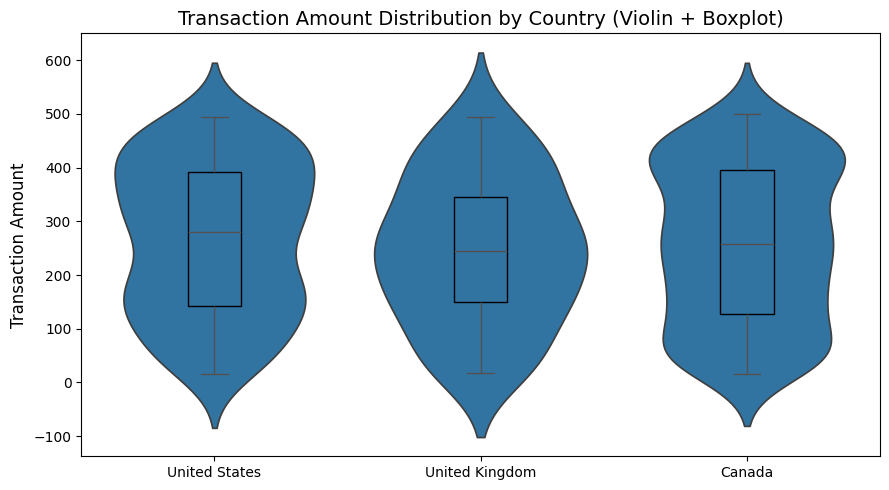

In [155]:
plt.figure(figsize=(9, 5))

sns.violinplot(
    data=merged_successful_transactions_user,
    x = "country",
    y = "amount",
    legend=False,
    inner=None,
)

sns.boxplot(
    data=merged_successful_transactions_user,
    x = "country",
    y = "amount",
    width=0.2,
    boxprops={'facecolor': 'none', 'edgecolor': 'black'},
)
             
plt.title("Transaction Amount Distribution by Country (Violin + Boxplot)", fontsize=14)
plt.xlabel("")
plt.ylabel("Transaction Amount", fontsize=12)
plt.tight_layout()
plt.show()

Transaction Amount Distribution by Country (Violin + Boxplot):

Este gráfico muestra cómo se distribuyen los montos de transacciones en tres países: Estados Unidos, Reino Unido y Canadá.

Cada figura en forma de “violín” representa la distribución de los datos para cada país: Las partes más anchas indican que hay más transacciones con esos valores. Las partes más delgadas muestran que hay menos transacciones en esos rangos.
Dentro de cada violín hay un boxplot. La línea del medio indica la mediana, la caja muestra el rango donde se encuentran el 50% de los datos. Las bigotes arriba y abajo muestran el resto de los datos, excepto valores atípicos.

En Estados Unidos, la distribución es bastante equilibrada, pero se ve que hay más transacciones con montos altos (entre 300 y 450), ya que la parte de arriba del violín es más ancha.
En Reino Unido, la mediana es más baja. Además, tiene una mayor dispersión en la parte baja del gráfico, lo que significa que hay más transacciones con montos bajos en comparación con los otros países.
En Canadá, la mediana es la más alta. La parte superior del violín es ancha, lo que indica que hay más transacciones con montos altos. Esto sugiere que, en general, los usuarios en Canadá gastan más por transacción que en los otros países.


Exercici 2
Genera un FacetGrid per a visualitzar múltiples aspectes de les dades simultàniament.

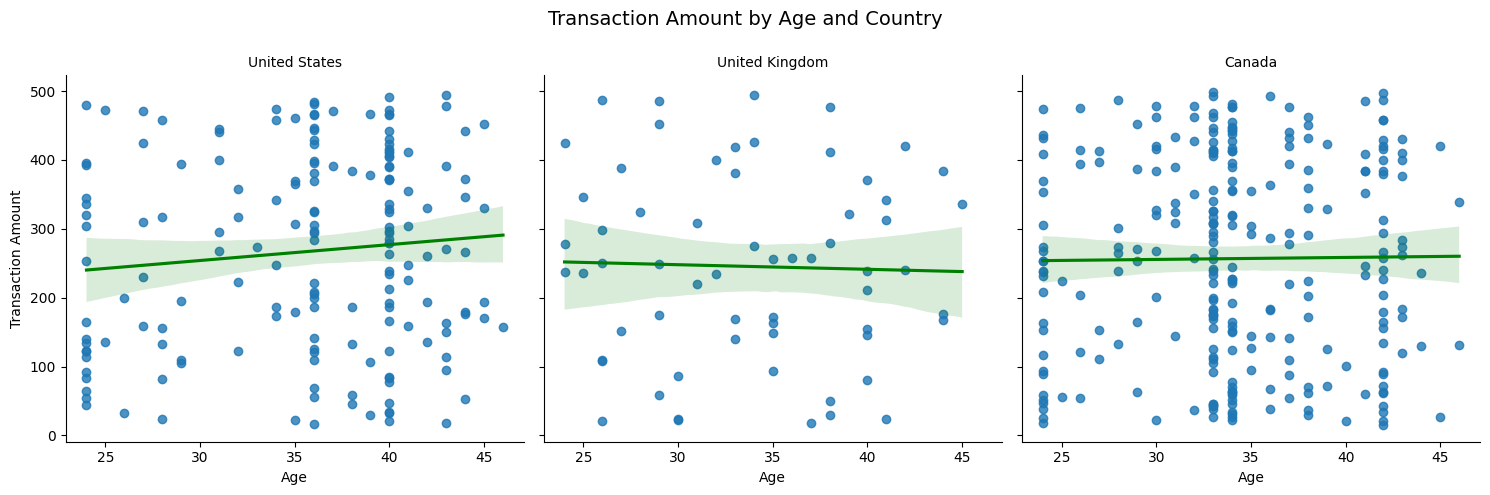

In [147]:
fg = sns.FacetGrid(
    merged_successful_transactions_user, 
    col = "country", 
    height=5, 
    aspect=1
)

fg.map_dataframe(
    sns.regplot, 
    x = "age", 
    y = "amount", 
    line_kws={'color': 'green'}
)

fg.set_axis_labels("Age", "Transaction Amount")
fg.set_titles("{col_name}")
fg.figure.subplots_adjust(top=0.85)
fg.figure.suptitle("Transaction Amount by Age and Country", fontsize=14)
plt.show()


In [148]:
for country, group in merged_successful_transactions_user.groupby('country'):
    slope, intercept, r_value, p_value, std_err = linregress(group['age'], group['amount'])
    print(f"{country} → Slope: {slope:.2f}, Intercept: {intercept:.2f}, R²: {r_value**2:.3f}")

Canada → Slope: 0.29, Intercept: 246.93, R²: 0.000
United Kingdom → Slope: -0.67, Intercept: 267.89, R²: 0.001
United States → Slope: 2.31, Intercept: 184.87, R²: 0.010


Transaction Amount by Age and Country:
Este gráfico muestra la relación entre la edad y el monto de transacción en United States, United Kingdom y Canada. En todos los países, la pendiente de la línea de regresión es muy baja, lo que indica una relación débil o casi nula entre edad y gasto. Aunque en United States la línea sube un poco más, los valores de R² en los tres casos son muy bajos, lo que confirma que la edad no es un buen predictor del monto de transacción. En resumen,  no hay una tendencia clara EN GASTOS según la edad
